# Intro

Ensembles can be catogarised into two types, those who train while being aware of the data (putting weights) like AdaBoost and GardientBoost, and those which resample the data like random forest.
In general the boosters take care of bias while the baggers (forest) take care of variance. We believe that we have huge variance and so we might find that the forest gives better performance for now, but in the next stage we will use our new methods to deal with variance in our data and see which is truly better.
For now lets find the best params to create a good random forest and a good AdaBoostClassifier (after finding that trees perform excellently on quote data random forest seems like a good competitor although it is not possible to change its base estimator in sklearn).

In [9]:
from Utilities.orginizers import LearningData, TrainingData
from sklearn.model_selection import KFold, cross_val_score
from itertools import product
from random import sample
from multiprocessing import Pool
import matplotlib.pyplot as plt
import Utilities
import numpy as np
import warnings

%matplotlib inline

ld = LearningData()

In [10]:
import logging 

stock_names = ('SHW', 'MNK', 'BIO', 'KYTH', 'KRO')
logging.getLogger().setLevel(logging.ERROR)
stocks = [TrainingData(sn, ld=ld).add_history(10).set_threshold(0.8).get() for sn in stock_names]

In [3]:
import os
print(os.linesep.join(['{} {}'.format(sn, len(data)) for sn, (data, classes) in zip(stock_names, stocks)]))
print(stocks[0][0].describe())

SHW 7855
MNK 819
BIO 2815
KYTH 718
KRO 3220
             change        close   ex-divident         high           low  \
count  7.855000e+03  7855.000000  7.855000e+03  7855.000000  7.855000e+03   
mean   2.170977e-17     0.000000  1.447318e-17     0.000000 -1.447318e-16   
std    1.000064e+00     1.000064  1.000064e+00     1.000064  1.000064e+00   
min   -9.826291e-01    -0.711964 -8.285474e-02    -0.708525 -7.122042e-01   
25%   -6.546142e-01    -0.545740 -8.285474e-02    -0.546135 -5.453623e-01   
50%   -2.623907e-01    -0.438244 -8.285474e-02    -0.440260 -4.366827e-01   
75%    3.430775e-01    -0.053682 -8.285474e-02    -0.052620 -5.562959e-02   
max    1.404981e+01     3.669051  2.486545e+01     3.637710  3.656416e+00   

               open   split_ratio        volume  change1_days_before  \
count  7.855000e+03  7.855000e+03  7.855000e+03         7.855000e+03   
mean  -5.789272e-17 -4.052491e-16 -5.789272e-17         2.170977e-17   
std    1.000064e+00  1.000064e+00  1.000064e+0

In [11]:
def run_model(model, stocks=stocks):
    scores = {sn: [] for sn in stock_names}
    for sn, (data, classes) in zip(stock_names, stocks):
        scores[sn] = (sum(cross_val_score(model, data, classes))/3) 
    return scores

def get_best_model(models, accs):
    best_model = (0 , models[0])
    for model, accs in zip(models, accs):
        if sum(accs.values()) > best_model[0]:
            best_model = (sum(accs.values()), model)
    return best_model

def median(lst):
    quotient, remainder = divmod(len(lst), 2)
    if remainder:
        return sorted(lst)[quotient]
    return sum(sorted(lst)[quotient - 1:quotient + 1]) / 2.

def get_best_median_model(models, accs):
    best_model = (0 , models[0])
    for model, accs in zip(models, accs):
        if median(accs.values()) > best_model[0]:
            best_model = (median(accs.values()), model)
    return best_model

# Basic

And off we go!
We start from basic playing with parameters (run time is difficult).


In [24]:
from sklearn.ensemble import AdaBoostClassifier

n_estimators = [25, 50, 100, 200]
learning_rate = [0.5, 1.0, 1.5]

# create iterables for all options and use itertools product
anemodels = [AdaBoostClassifier(n_estimators=ne) for ne in n_estimators]
alrmodels = [AdaBoostClassifier(learning_rate=lr) for lr in learning_rate]

In [12]:
best_cut=23

In [26]:
import pandas
tree_stocks = [(pandas.get_dummies(data.apply(lambda s: pandas.qcut(s.rank(method='first'), best_cut))), classes) for data, classes in stocks]

In [27]:
def run_model_t(model):
    return run_model(model, tree_stocks)
aneaccuracies = list(map(run_model_t, anemodels))
alraccuracies = list(map(run_model_t, alrmodels))

In [28]:
from pandas import DataFrame

# data should be list of lists and each row should be:
# criterion, max_depth, min_samples, stock, accuracy
data = []
for tmodel, taccs in zip(anemodels, aneaccuracies):
    for tsn, tacc in taccs.items():
        data.append((tmodel.n_estimators, tsn, tacc))
aneresults = DataFrame(data, columns=('n_estimators', 'stock', 'accuracy'))

In [32]:
data = []
for tmodel, taccs in zip(alrmodels, alraccuracies):
    for tsn, tacc in taccs.items():
        data.append((tmodel.learning_rate, tsn, tacc))
alrresults = DataFrame(data, columns=('learning_rate', 'stock', 'accuracy'))

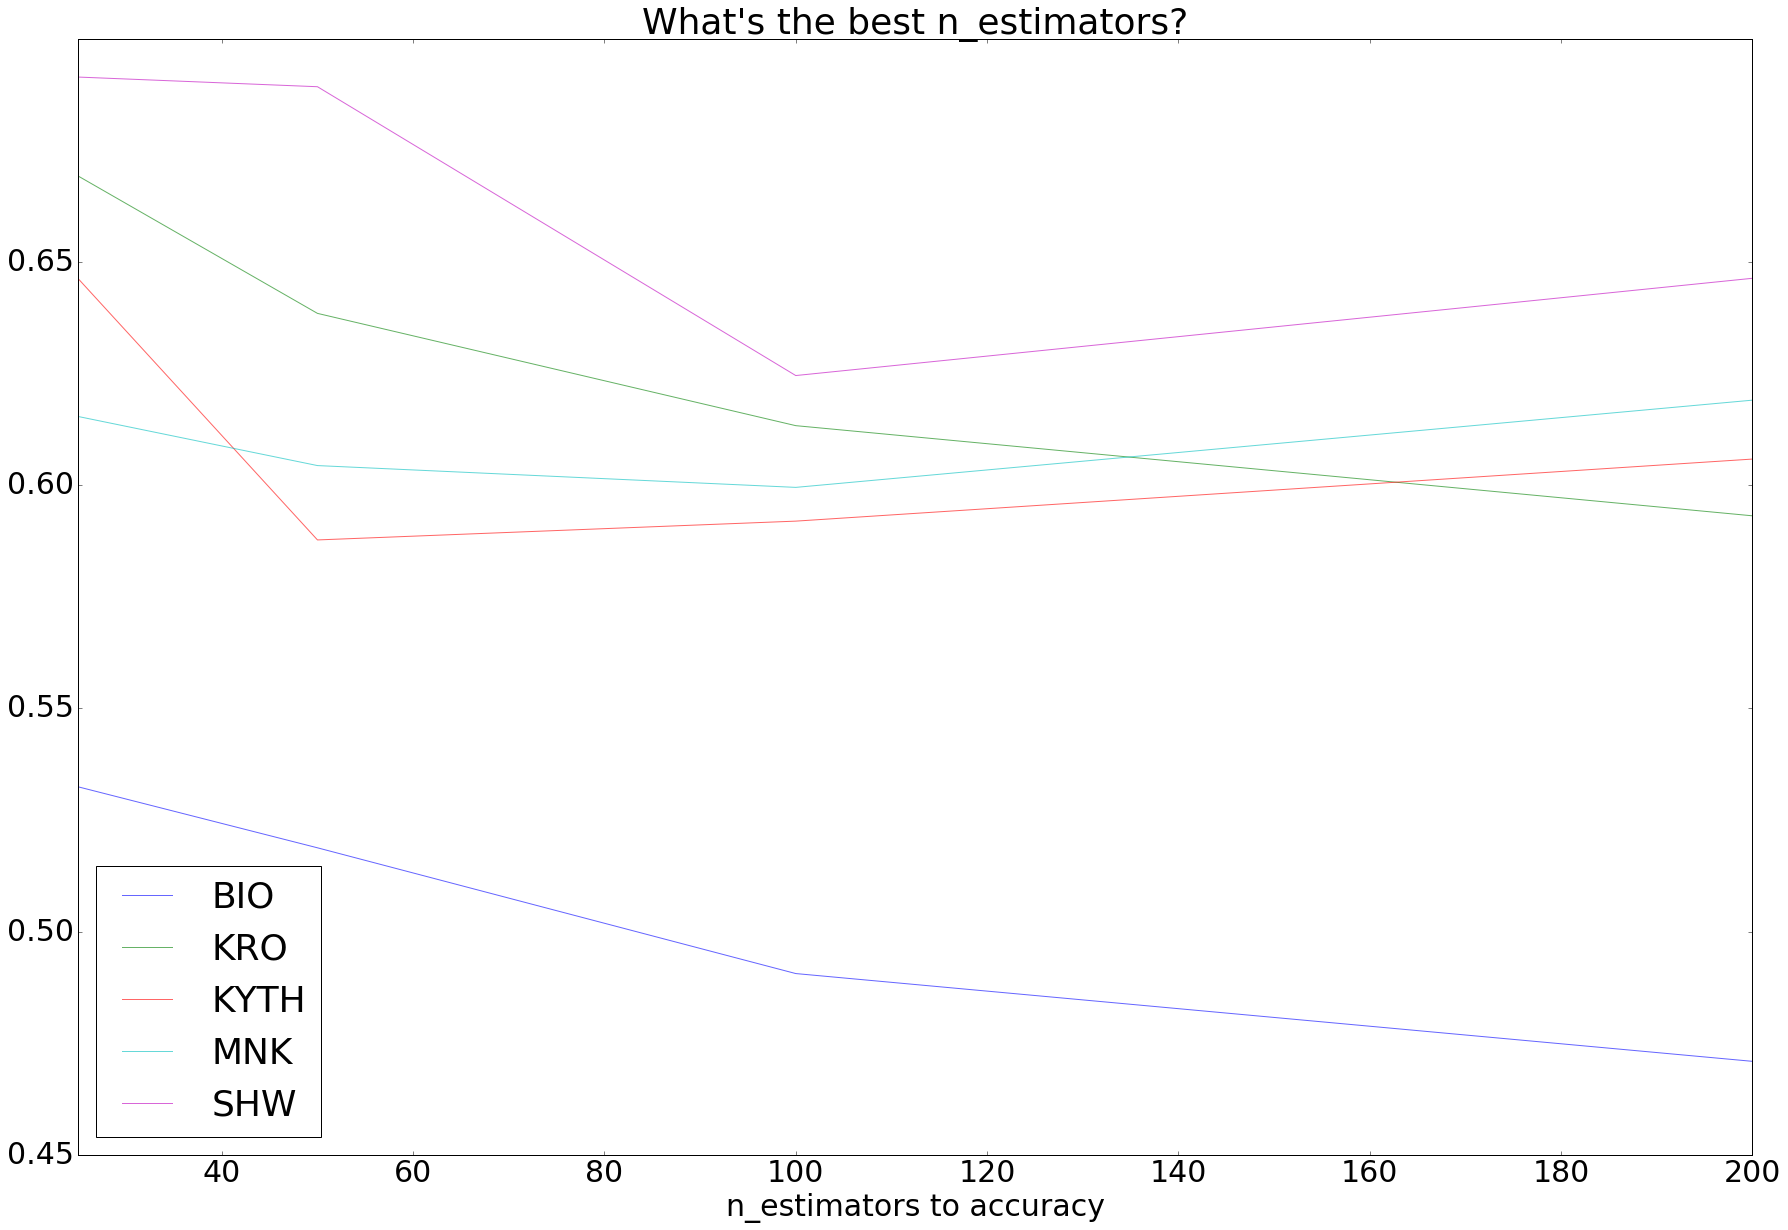

In [33]:
import numpy as np

%matplotlib inline

plt.rc('font', size=30)
fig = plt.figure(figsize=(30, 20))
alpha = 0.6

ax1 = plt.subplot2grid((1,1), (0,0))
for name, group in aneresults.groupby('stock'):
    # since we are counting values it makes sense to regularize the counts
    group.replace(np.nan, 12).groupby('n_estimators').agg('mean')['accuracy'].plot(kind='line', label=name, alpha=alpha)
ax1.set_xlabel('n_estimators to accuracy')
plt.legend(loc='best')
ax1.set_title("What's the best n_estimators?" )

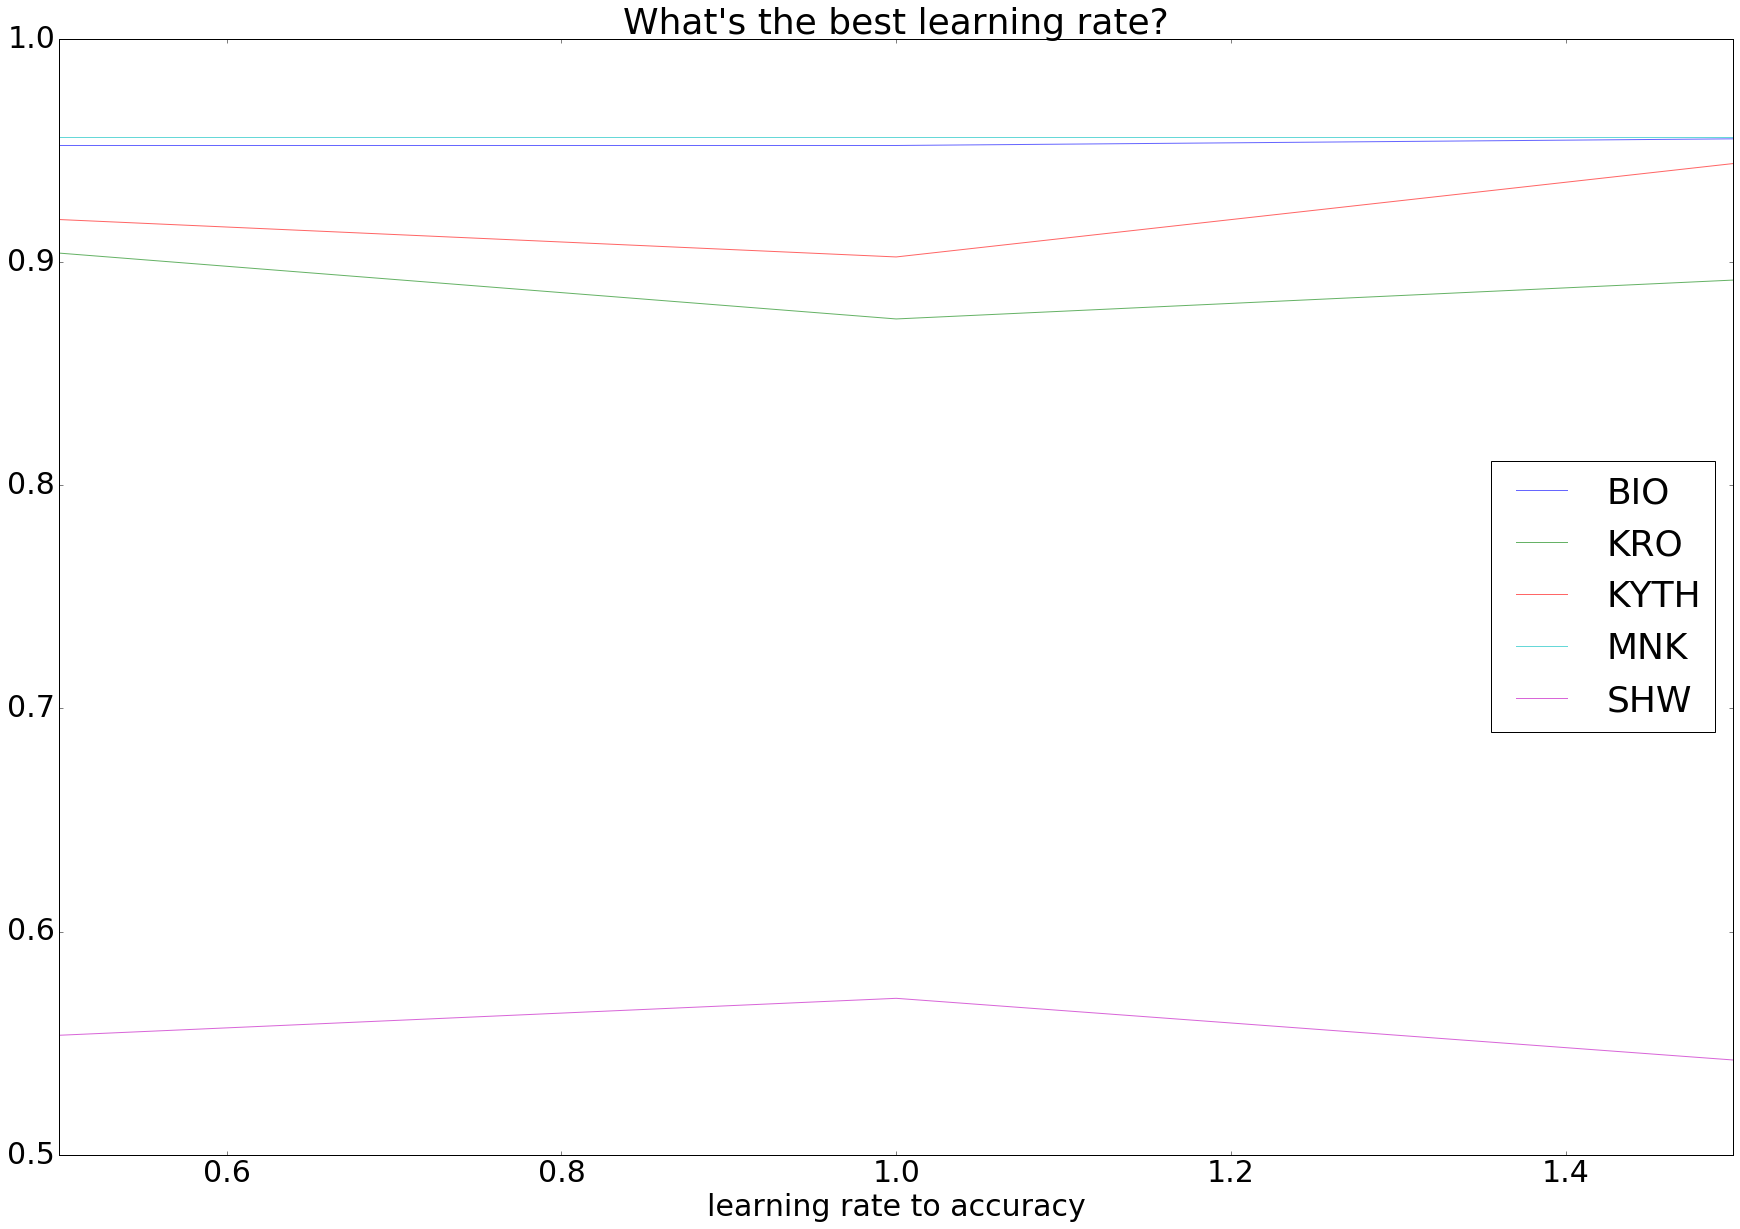

In [52]:
import numpy as np

%matplotlib inline

plt.rc('font', size=30)
fig = plt.figure(figsize=(30, 20))
alpha = 0.6

ax1 = plt.subplot2grid((1,1), (0,0))
for name, group in alrresults.groupby('stock'):
    # since we are counting values it makes sense to regularize the counts
    group.replace(np.nan, 12).groupby('learning_rate').agg('mean')['accuracy'].plot(kind='line', label=name, alpha=alpha)
ax1.set_xlabel('learning rate to accuracy')
plt.legend(loc='best')
ax1.set_title("What's the best learning rate?" )

Now with a different threshold

In [35]:
import logging 

stock_names = ('SHW', 'MNK', 'BIO', 'KYTH', 'KRO')
logging.getLogger().setLevel(logging.ERROR)
stocks = [TrainingData(sn, ld=ld).add_history(10).set_threshold('default').get() for sn in stock_names]
import pandas
tree_stocks = [(pandas.get_dummies(data.apply(lambda s: pandas.qcut(s.rank(method='first'), best_cut))), classes) for data, classes in stocks]

In [36]:
def run_model_t(model):
    return run_model(model, tree_stocks)
aneaccuracies = list(map(run_model_t, anemodels))
alraccuracies = list(map(run_model_t, alrmodels))

/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:579: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:579: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:579: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:579: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of 

In [37]:
from pandas import DataFrame

# data should be list of lists and each row should be:
# criterion, max_depth, min_samples, stock, accuracy
data = []
for tmodel, taccs in zip(anemodels, aneaccuracies):
    for tsn, tacc in taccs.items():
        data.append((tmodel.n_estimators, tsn, tacc))
aneresults = DataFrame(data, columns=('n_estimators', 'stock', 'accuracy'))

In [38]:
data = []
for tmodel, taccs in zip(alrmodels, alraccuracies):
    for tsn, tacc in taccs.items():
        data.append((tmodel.learning_rate, tsn, tacc))
alrresults = DataFrame(data, columns=('learning_rate', 'stock', 'accuracy'))

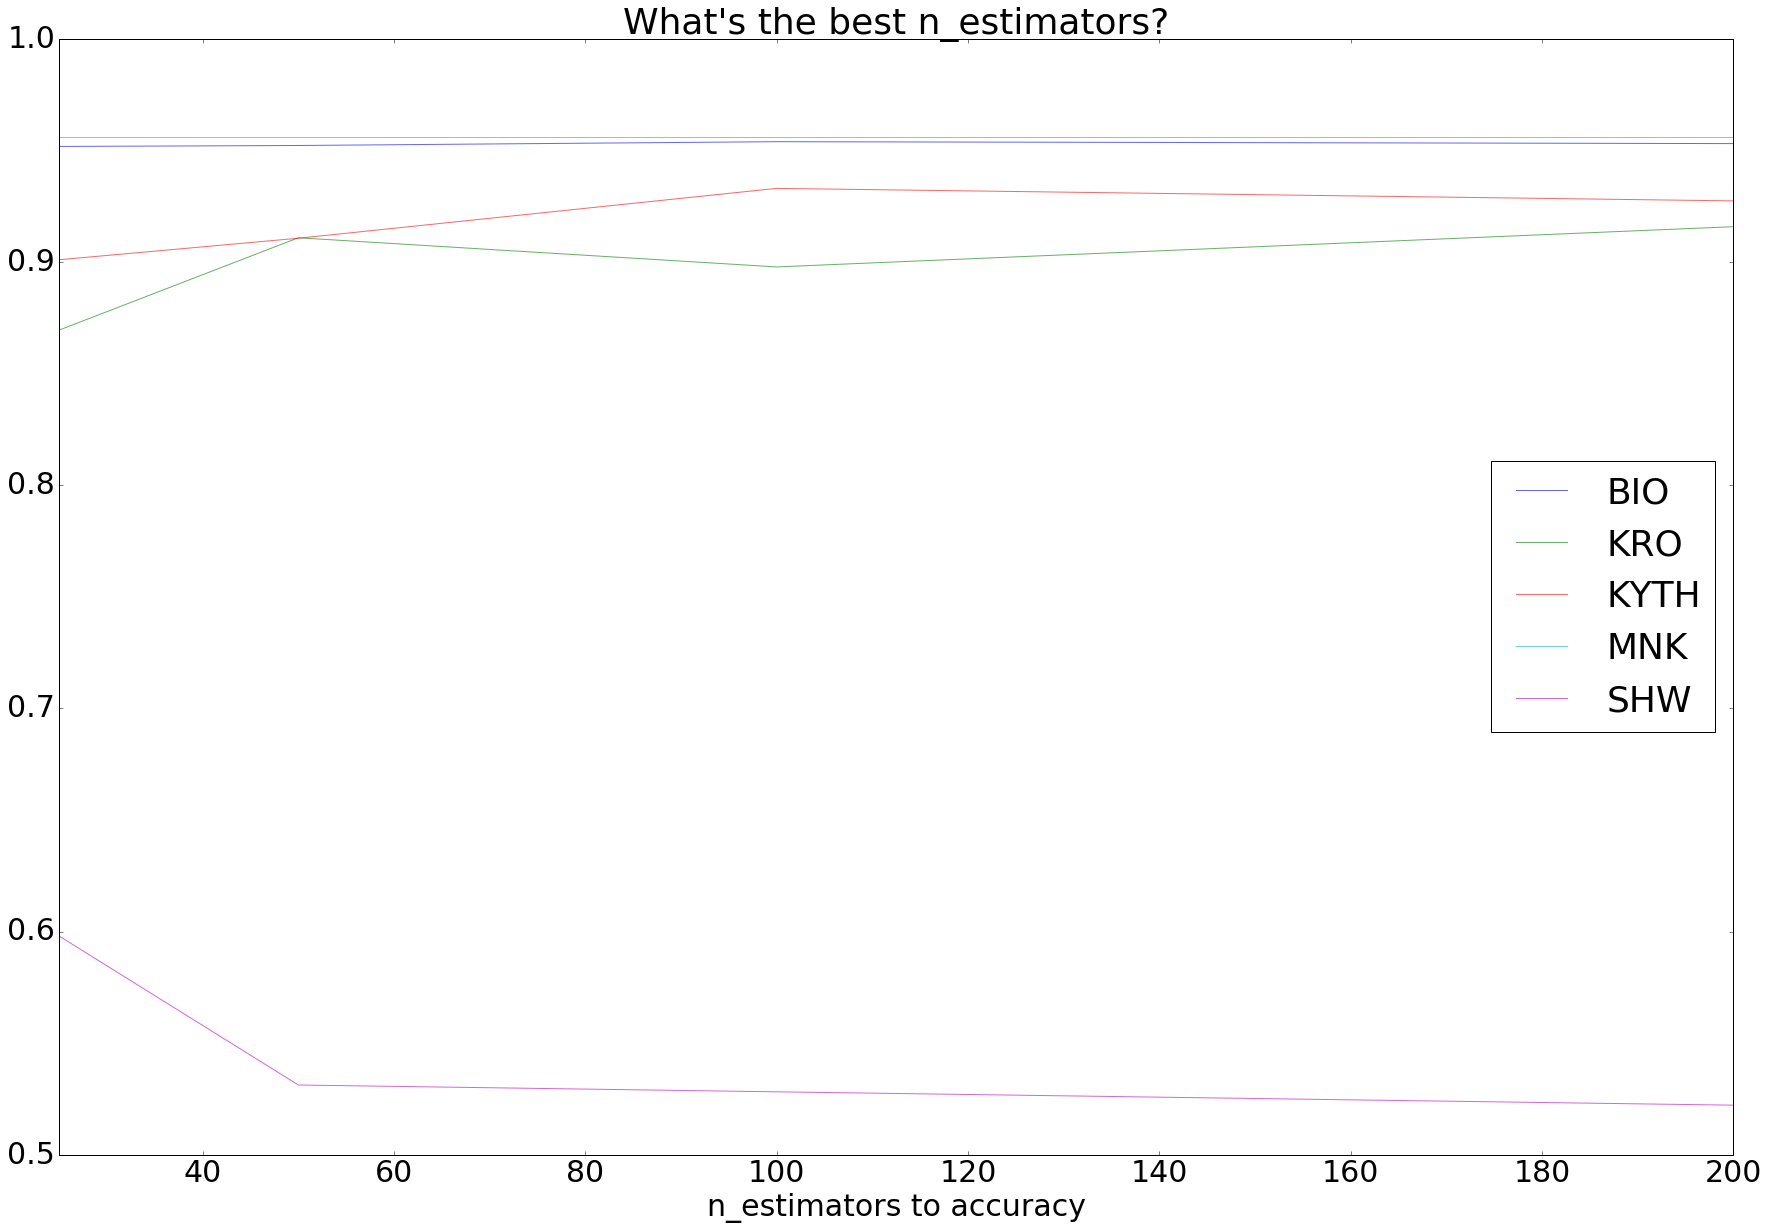

In [39]:
import numpy as np

%matplotlib inline

plt.rc('font', size=30)
fig = plt.figure(figsize=(30, 20))
alpha = 0.6

ax1 = plt.subplot2grid((1,1), (0,0))
for name, group in aneresults.groupby('stock'):
    # since we are counting values it makes sense to regularize the counts
    group.replace(np.nan, 12).groupby('n_estimators').agg('mean')['accuracy'].plot(kind='line', label=name, alpha=alpha)
ax1.set_xlabel('n_estimators to accuracy')
plt.legend(loc='best')
ax1.set_title("What's the best n_estimators?" )

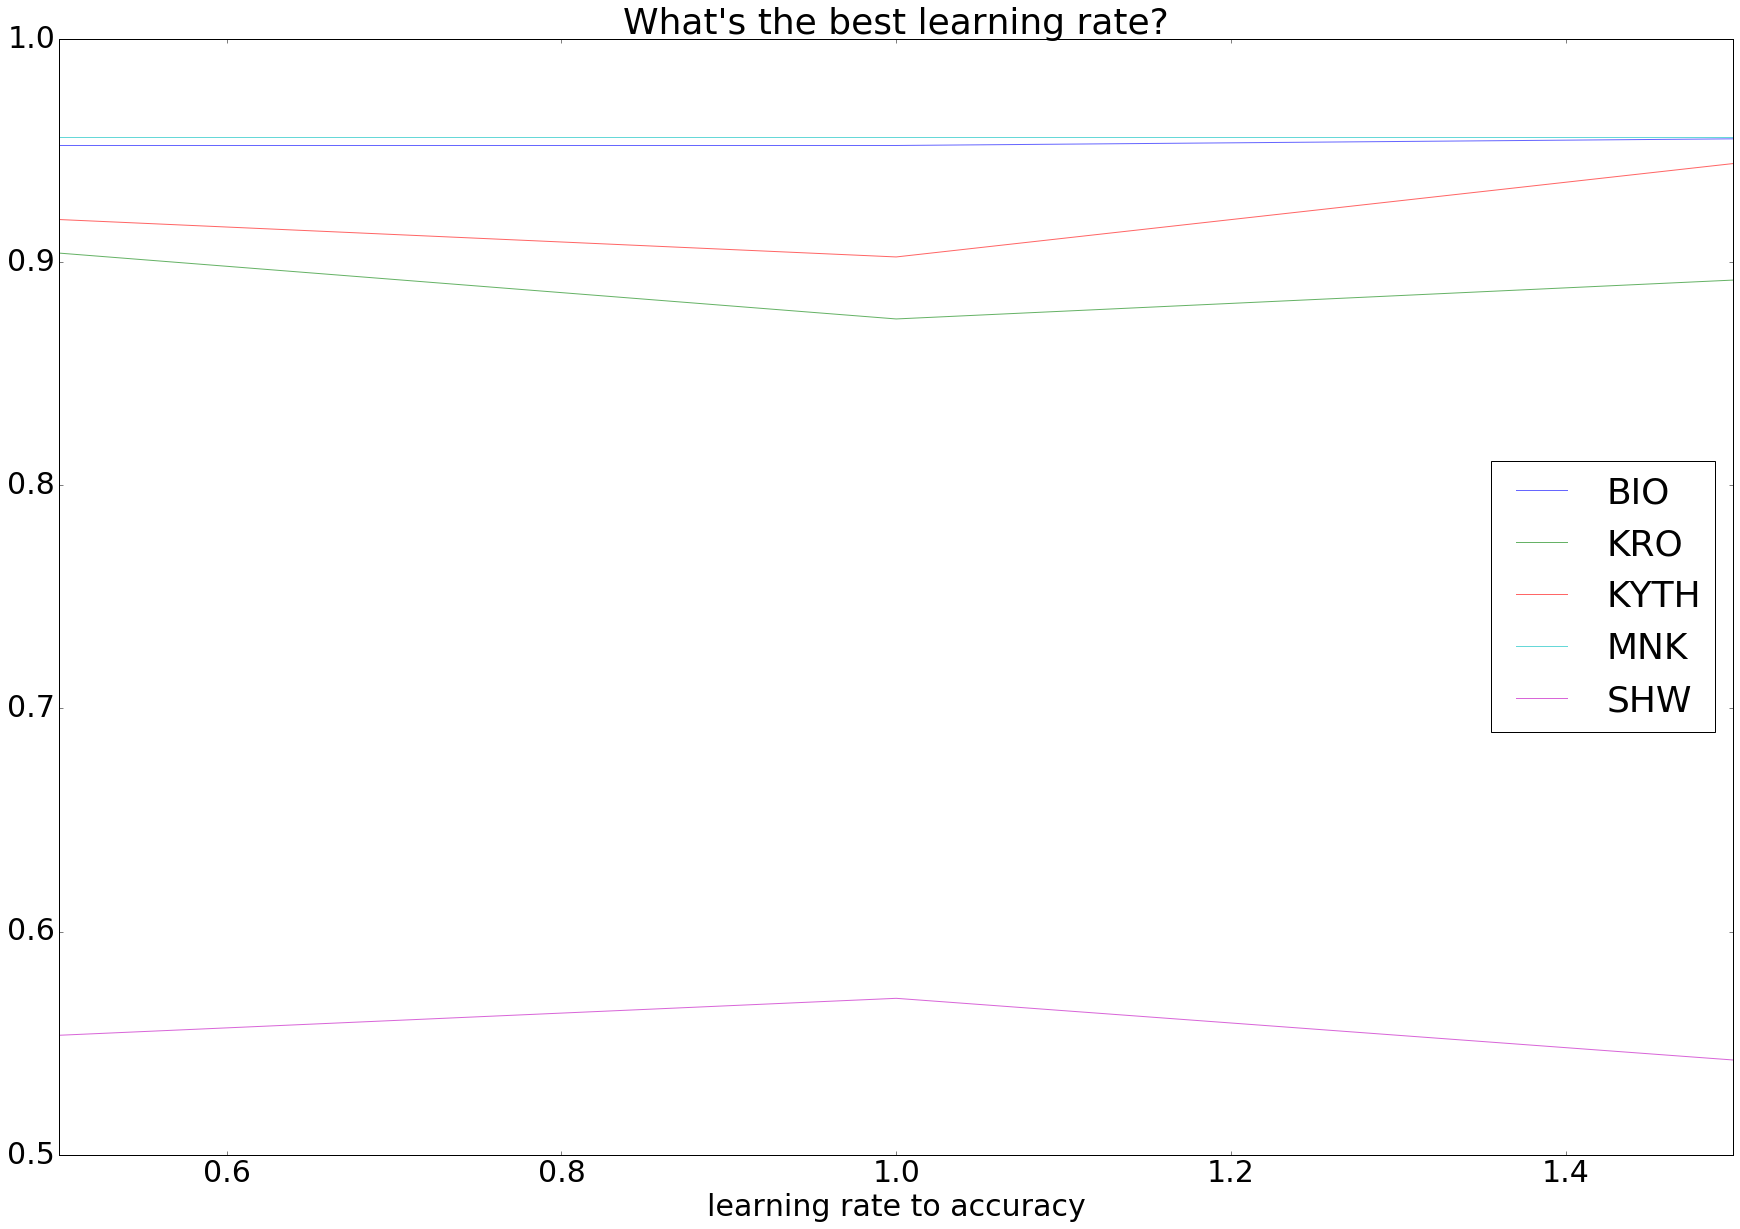

In [43]:
import numpy as np

%matplotlib inline

plt.rc('font', size=30)
fig = plt.figure(figsize=(30, 20))
alpha = 0.6

ax1 = plt.subplot2grid((1,1), (0,0))
for name, group in alrresults.groupby('stock'):
    # since we are counting values it makes sense to regularize the counts
    group.replace(np.nan, 12).groupby('learning_rate').agg('mean')['accuracy'].plot(kind='line', label=name, alpha=alpha)
ax1.set_xlabel('learning rate to accuracy')
plt.legend(loc='best')
ax1.set_title("What's the best learning rate?" )

In [42]:
for d, c in tree_stocks:
    print((c == True).sum()/float(len(c)))

0.940674729472
0.998778998779
0.994878361076
0.984679665738
0.980745341615


In [45]:
for name, group in alrresults.groupby('learning_rate'):
    print(group.replace(np.nan, 12).groupby('stock').agg('mean')['accuracy'])

stock
BIO     0.952198
KRO     0.903986
KYTH    0.919024
MNK     0.955891
SHW     0.553553
Name: accuracy, dtype: float64
stock
BIO     0.952198
KRO     0.874484
KYTH    0.902264
MNK     0.955891
SHW     0.570106
Name: accuracy, dtype: float64
stock
BIO     0.955186
KRO     0.891899
KYTH    0.944106
MNK     0.955891
SHW     0.542477
Name: accuracy, dtype: float64


# Variance Reduction
We will try 3 approches. 

    1. using standard sklearn feature selection. 
    2. using QuarterClusterer try using data with less variance.
    3. using relation strength classifier.

In [7]:
import sklearn.ensemble 
from sklearn.ensemble import AdaBoostClassifier
accs = run_model(AdaBoostClassifier())
print(sum(accs.values()))

2.88161662544


## Standard feature selection

We have plenty of samples so it seems wiser to use mutual_info score func, and trying to remove features by those who have small variance.

In [13]:
stocks = [TrainingData(sn, ld=ld).add_history(10).set_threshold(0.8).get() for sn in stock_names]
import pandas
tree_stocks = [(pandas.get_dummies(data.apply(lambda s: pandas.qcut(s.rank(method='first'), best_cut))), classes) for data, classes in stocks]

In [50]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif

filtered_tree_stocks = [(SelectKBest(score_func=mutual_info_classif, k=11).fit_transform(data, classes), classes) for data, classes in tree_stocks]
results = ((11, sum(run_model(AdaBoostClassifier(), filtered_tree_stocks).values())))
    
print('{} {}'.format(results[0], results[1]))


11 3.917170323663889


We will now check if the solution is trivial

In [16]:
true_scores = []
false_scores = []

models = [AdaBoostClassifier()]

train_data = [(d.iloc[0:round(len(d)*0.7)], c.iloc[0:round(len(d)*0.7)]) for d, c in stocks]
test_data = [(d.iloc[round(len(d)*0.7):len(d)-1], c.iloc[round(len(d)*0.7):len(d)-1]) for d, c in stocks]
trues = [(d.loc[c.index[c == True]], c.loc[c.index[c == True]]) for d, c in test_data]
falses = [(d.loc[c.index[c == False]], c.loc[c.index[c == False]]) for d, c in test_data]

for m in models:
    true_scores.append([])
    false_scores.append([])
    for (d, c), (td, tc), (fd, fc) in zip(train_data, trues, falses):
        m.fit(d, c)
        tc[0]= False
        fc[0]= True
        true_scores[-1].append(m.score(td, tc))
        false_scores[-1].append(m.score(fd.fillna(0), fc))

In [17]:
def mean(numbers):
    return float(sum(numbers)) / max(len(numbers), 1)

In [18]:
for t,f in zip(true_scores,false_scores):
    print("score: "+str(100*(mean(f)*0.8+mean(t)*0.2))+" True positive: "+str(mean(t))+" False positive: "+str(mean(f)))

score: 76.6805193609545 True positive: 0.16804130167602138 False positive: 0.9164961665929259


Now quite as trivial as we suspected

In [51]:
from sklearn.feature_selection import VarianceThreshold

results2 = []
for i in range(1, 11):
    try:
        filtered_tree_stocks = [(VarianceThreshold(threshold=float(i)/100).fit_transform(data, classes), classes) for data, classes in tree_stocks]
        results2.append((i, sum(run_model(AdaBoostClassifier(), filtered_tree_stocks).values())))
    except Exception as e:
        print('Skipping threshold {} as it doesnt have enough variance: {}'.format(float(i)/100, str(e)))
    
results2.sort(key=lambda t: t[1])
for t in results2:
    print('{} {}'.format(t[0],t[1]))

Skipping threshold 0.05 as it doesnt have enough variance: No feature in X meets the variance threshold 0.05000
Skipping threshold 0.06 as it doesnt have enough variance: No feature in X meets the variance threshold 0.06000
Skipping threshold 0.07 as it doesnt have enough variance: No feature in X meets the variance threshold 0.07000
Skipping threshold 0.08 as it doesnt have enough variance: No feature in X meets the variance threshold 0.08000
Skipping threshold 0.09 as it doesnt have enough variance: No feature in X meets the variance threshold 0.09000
Skipping threshold 0.1 as it doesnt have enough variance: No feature in X meets the variance threshold 0.10000
1 3.004946969241326
2 3.033186264517214
4 3.0529008719294857
3 3.0837480568307


#### test using deafult thereshold

In [ ]:
stocks = [TrainingData(sn, ld=ld).add_history(10).set_threshold('default').get() for sn in stock_names]
import pandas
tree_stocks = [(pandas.get_dummies(data.apply(lambda s: pandas.qcut(s.rank(method='first'), best_cut))), classes) for data, classes in stocks]

In [47]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif

filtered_tree_stocks = [(SelectKBest(score_func=mutual_info_classif, k=11).fit_transform(data, classes), classes) for data, classes in tree_stocks]
results = ((11, sum(run_model(AdaBoostClassifier(), filtered_tree_stocks).values())))
    
print('{} {}'.format(results[0], results[1]))


11 4.7969189639047745


/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:579: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


In [48]:
from sklearn.feature_selection import VarianceThreshold

results2 = []
for i in range(1, 11):
    try:
        filtered_tree_stocks = [(VarianceThreshold(threshold=float(i)/100).fit_transform(data, classes), classes) for data, classes in tree_stocks]
        results2.append((i, sum(run_model(AdaBoostClassifier(), filtered_tree_stocks).values())))
    except Exception as e:
        print('Skipping threshold {} as it doesnt have enough variance: {}'.format(float(i)/100, str(e)))
    
results2.sort(key=lambda t: t[1])
for t in results2:
    print('{} {}'.format(t[0],t[1]))

/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:579: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:579: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:579: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:579: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of 

Skipping threshold 0.05 as it doesnt have enough variance: No feature in X meets the variance threshold 0.05000
Skipping threshold 0.06 as it doesnt have enough variance: No feature in X meets the variance threshold 0.06000
Skipping threshold 0.07 as it doesnt have enough variance: No feature in X meets the variance threshold 0.07000
Skipping threshold 0.08 as it doesnt have enough variance: No feature in X meets the variance threshold 0.08000
Skipping threshold 0.09 as it doesnt have enough variance: No feature in X meets the variance threshold 0.09000
Skipping threshold 0.1 as it doesnt have enough variance: No feature in X meets the variance threshold 0.10000
3 4.212987778099637
2 4.216800047844641
1 4.252345148167111
4 4.278449420165802
